In [424]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [425]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [426]:
df = pd.read_sql_query("DECLARE @from date, @to date;\
    SELECT\
        @from = getdate()\
        ,@to = dateadd(day, 1, getdate());\
\
SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE t.completedDateTime >= @from AND t.completedDateTime < @to AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service') and t.statusId = 2", cnxn)

In [427]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Apr 8 2022 6:40AM,16,"SHL Pharma, LLC",Picking,Justin Johnson,6
1,Apr 8 2022 7:02AM,16,Sartorius Bioprocess Solutions,Picking,Justin Johnson,7
2,Apr 8 2022 6:52AM,16,Sartorius Bioprocess Solutions,Picking,Justin Johnson,6
3,Apr 8 2022 6:41AM,16,"SHL Pharma, LLC",Picking Completed,Justin Johnson,6
4,Apr 8 2022 6:40AM,16,"SHL Pharma, LLC",Scanned Shipment,Justin Johnson,6


# WAREHOUSE

In [428]:
# Group By Warehouse
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,16,7


In [429]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [430]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [431]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
16,7


### All Operations type

In [432]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Picking,3
1,Picking Completed,2
2,Scanned Shipment,2


In [433]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [434]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Picking,3
1,Picking Completed,2
2,Scanned Shipment,2


In [435]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Picking,3
Picking Completed,2
Scanned Shipment,2


### Excluding Operations PICKING and RECEIVING

In [436]:
df_operation_excluded = df_operation.loc[(df_operation["operationCode"] != 'Picking') &
                                         (df_operation["operationCode"] != 'Receiving')]

In [437]:
# Save Data in JSON format
df_operation_excluded = df_operation_excluded.rename(columns={"project": "Tasks"})
df_operation_excluded_index = df_operation_excluded.set_index(['operationCode'])
df_operation_excluded_index.to_json('data/operations_type_excluded.json')
df_operation_excluded_index.head()

,Tasks
operationCode,
Picking Completed,2
Scanned Shipment,2


### Operations per Hour

In [438]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,6,6
1,7,1


In [439]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [440]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
6,6
7,1


# PICKING

In [441]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [442]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Justin Johnson,6,2
1,Justin Johnson,7,1


In [443]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,6,7
employee,,
Justin Johnson,2,1


### Save in JSON File

In [444]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Justin Johnson
6,2
7,1


### Picking By Warehouse Function

In [445]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [446]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('19')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# RECEIVING

In [447]:
# Filtered by Picking
receiving_df = df[df['operationCode'] == 'Receiving']
receiving_df.head()

,Date,warehouse,project,operationCode,employee,Hour


In [448]:
# Grouped by Employee and Hour
receiving_group_df = receiving_df.groupby(['employee', 'Hour']).count()[['operationCode']]
receiving_group_df.reset_index(inplace=True)
receiving_group_df.head()

,employee,Hour,operationCode


In [449]:
# Pivot
receiving_pivot_df = receiving_group_df.pivot(index='employee', columns='Hour', values='operationCode')
receiving_pivot_df = receiving_pivot_df.fillna(0)
receiving_pivot_df = receiving_pivot_df.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

receiving_pivot_df.head()

""
employee


In [450]:
# Save into JSON
receivers = receiving_pivot_df.T
receivers.to_json('data/receivers.json')
receivers.head()

employee


# INVENTORY

In [451]:
# Group By Operation Code and Warehouse
cycle_count_df = df.groupby(['operationCode', 'warehouse']).count()[['employee']]
cycle_count_df.reset_index(inplace=True)

In [452]:
# Filtering by Count, Recount and Inventory Adjustment
cc_df = cycle_count_df.loc[(cycle_count_df["operationCode"] == 'Count') |
                           (cycle_count_df["operationCode"] == 'Recount') |
                           (cycle_count_df["operationCode"] == 'Inventory Adjustment')]

cc_df = cc_df.rename(columns={'employee': 'count'})

In [453]:
cc_df_pivot = cc_df.pivot(index='operationCode', columns='warehouse', values='count')

In [454]:
try:
    cc_df_pivot.rename({'Count': 'Inventory Counts'}, axis='index', inplace=True)
except:
    print('Operation COUNT does not exist yet')
    
try:
    cc_df_pivot.rename({'Recount': 'Discrepancies'}, axis='index', inplace=True)
except:
    print('Operation DISCREPANCIES does not exist yet')
    
try:
    cc_df_pivot.rename({'Inventory Adjustment': 'Inventory Adjustments'}, axis='index', inplace=True)
except:
    print('Operation INVENTORY ADJUSTMENT does not exist yet')

In [455]:
cc_df_pivot = cc_df_pivot.fillna(0)
cc_df_pivot.to_json('data/cycle_count.json')
cc_df_pivot.head()

warehouse
operationCode


# QUERY 02: Open Outbounds

In [456]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [457]:
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447


In [458]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1716 days 22:21:16.423110
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,920 days 20:40:15.477110
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,875 days 14:53:40.827110
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,806 days 18:10:12.557110
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,806 days 18:10:12.173110


In [459]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1716 days 22:21:16.423110,1716,22
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,920 days 20:40:15.477110,920,20
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,875 days 14:53:40.827110,875,14
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,806 days 18:10:12.557110,806,18
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,806 days 18:10:12.173110,806,18


In [460]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [461]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [462]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [463]:
df_02_grouped

,orders
age_group,
24 Hours,665
48 Hours,163
72 Hours,214
1 Week,252
1 Month,1141
2 Months,653
3 Months,574
1 Year,2241
2 Years,1074


### Save in JSON File

In [464]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,665
48 Hours,163
72 Hours,214
1 Week,252
1 Month,1141
2 Months,653
3 Months,574
1 Year,2241
2 Years,1074


<AxesSubplot:ylabel='age_group'>

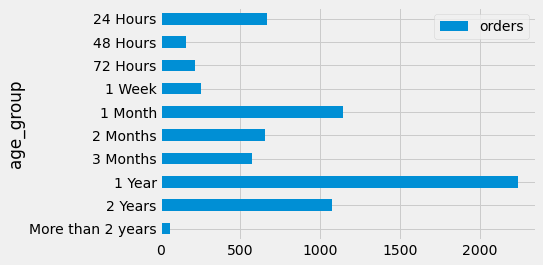

In [465]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

# QUERY 3: Picking Performance (Orders and Waves)

In [466]:
df03 = pd.read_sql_query("DECLARE @from date, @to date;\
                          SELECT @from = getdate(), @to = dateadd(day, 1, getdate());\
    SELECT t.completedDateTime Date, oc.name Operation, w.name Warehouse,\
           p.name Project, m.lookupCode Material, employee Employee, s.lookupCode Shipment, isnull(s.waveId, ps.waveId) Wave,\
           ordersPerWave.shipmentsCount, lc.name Location, o.orderClassId\
    FROM datex_footprint.Tasks t\
        join datex_footprint.OperationCodes oc\
            on oc.id = t.operationCodeId\
        left join datex_footprint.Warehouses w\
            on w.id = t.warehouseId\
        left join datex_footprint.Projects p\
            on p.id = t.projectId\
        left join datex_footprint.Materials m\
            on m.id = t.materialId\
        left join datex_footprint.Shipments s\
        inner join datex_footprint.ShipmentOrderLookup sol\
        inner join datex_footprint.orders o\
            on o.id = sol.orderId\
            on sol.shipmentId = s.id\
            on s.id = t.shipmentId\
        left join datex_footprint.PickSlips ps\
            on ps.id = t.pickSlipId\
        left join datex_footprint.LocationContainers lc\
            on lc.id = t.actualSourceLocationId\
        outer apply (\
            select\
                count(distinct tt.shipmentId) shipmentsCount\
                from datex_footprint.waves ww\
                    inner join datex_footprint.PickSlips ppss\
                    inner join datex_footprint.tasks tt\
                        on tt.operationCodeId = 8 and tt.pickSlipId = ppss.id\
                        on ppss.waveId = ww.id\
                where ww.id = isnull(s.waveId, ps.waveId)) ordersPerWave\
    where t.completedDateTime >= @from and t.completedDateTime < @to and t.statusId = 2 and isnull(o.orderClassId, 0) not in (23, 24, 36) and s.lookupCode not like '%TEST%'\
    and t.operationCodeId in (8, 39, 2064, 2065, 2066, 2067, 2068) and t.employee != 'Foot Print Service'\
    order by s.lookupCode, t.completedDateTime", cnxn)

In [467]:
df03.tail(3)

,Date,Operation,Warehouse,Project,Material,Employee,Shipment,Wave,shipmentsCount,Location,orderClassId
4,2022-04-08 06:40:34.347,Scanned Shipment,16,"SHL Pharma, LLC",None,Justin Johnson,SHL-7858943,233619,1,None,2
5,2022-04-08 06:40:57.857,Picking,16,"SHL Pharma, LLC",TS-205-US,Justin Johnson,SHL-7858943,233619,1,41-08-03-A,2
6,2022-04-08 06:41:06.327,Picking Completed,16,"SHL Pharma, LLC",None,Justin Johnson,SHL-7858943,233619,1,None,2


In [468]:
# Order Columns
df03 = df03[['Warehouse', 'Project', 'Wave', 'Shipment', 'Date', 'Operation', 'Employee',
             'Location', 'shipmentsCount', 'Material']]

### Filter by Shipments

In [469]:
# Filter by Orders only
df03_orders = df03.loc[(df03['Operation']=='Picking') |
                       (df03['Operation']=='Scanned Shipment') |
                       (df03['Operation']=='Picking Completed')]

df03_orders = df03_orders[['Warehouse', 'Project', 'Shipment', 'Date', 'Operation', 'Employee', 'Location']]

df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location
0,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:50:21.733,Scanned Shipment,Justin Johnson,None
1,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:52:48.617,Picking,Justin Johnson,13-02-01-B
2,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:53:03.363,Picking Completed,Justin Johnson,None
3,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 07:02:20.477,Picking,Justin Johnson,14-08-01-B
4,16,"SHL Pharma, LLC",SHL-7858943,2022-04-08 06:40:34.347,Scanned Shipment,Justin Johnson,None


In [470]:
# Create a new column with the time difference between rows
df03_orders['PickingTime'] = df03_orders['Date'].diff()
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime
0,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:50:21.733,Scanned Shipment,Justin Johnson,None,NaT
1,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:52:48.617,Picking,Justin Johnson,13-02-01-B,0 days 00:02:26.884000
2,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:53:03.363,Picking Completed,Justin Johnson,None,0 days 00:00:14.746000
3,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 07:02:20.477,Picking,Justin Johnson,14-08-01-B,0 days 00:09:17.114000
4,16,"SHL Pharma, LLC",SHL-7858943,2022-04-08 06:40:34.347,Scanned Shipment,Justin Johnson,None,-1 days +23:38:13.870000


In [471]:
# Add Hour, Minute and Second columns
df03_orders['hour'] = df03_orders['PickingTime'].dt.components['hours']
df03_orders['minute'] = df03_orders['PickingTime'].dt.components['minutes']
df03_orders['second'] = df03_orders['PickingTime'].dt.components['seconds']
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
0,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:50:21.733,Scanned Shipment,Justin Johnson,None,NaT,NaN,NaN,NaN
1,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:52:48.617,Picking,Justin Johnson,13-02-01-B,0 days 00:02:26.884000,0.0,2.0,26.0
2,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:53:03.363,Picking Completed,Justin Johnson,None,0 days 00:00:14.746000,0.0,0.0,14.0
3,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 07:02:20.477,Picking,Justin Johnson,14-08-01-B,0 days 00:09:17.114000,0.0,9.0,17.0
4,16,"SHL Pharma, LLC",SHL-7858943,2022-04-08 06:40:34.347,Scanned Shipment,Justin Johnson,None,-1 days +23:38:13.870000,23.0,38.0,13.0


In [472]:
# Set all the Scanned Shipment hour, minute, time to ZERO
df03_orders_modified = df03_orders

df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'hour'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'minute'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'second'] = 0.0

df03_orders_modified.loc[df03_orders_modified['Operation'] == 'Scanned Shipment'].head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
0,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:50:21.733,Scanned Shipment,Justin Johnson,None,NaT,0.0,0.0,0.0
4,16,"SHL Pharma, LLC",SHL-7858943,2022-04-08 06:40:34.347,Scanned Shipment,Justin Johnson,None,-1 days +23:38:13.870000,0.0,0.0,0.0


In [473]:
df03_orders_modified['Time'] = df03_orders_modified['hour']*60 + df03_orders_modified['minute'] + df03_orders_modified['second']/60
df03_orders_modified.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
0,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:50:21.733,Scanned Shipment,Justin Johnson,None,NaT,0.0,0.0,0.0,0.000000
1,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:52:48.617,Picking,Justin Johnson,13-02-01-B,0 days 00:02:26.884000,0.0,2.0,26.0,2.433333
2,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:53:03.363,Picking Completed,Justin Johnson,None,0 days 00:00:14.746000,0.0,0.0,14.0,0.233333
3,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 07:02:20.477,Picking,Justin Johnson,14-08-01-B,0 days 00:09:17.114000,0.0,9.0,17.0,9.283333
4,16,"SHL Pharma, LLC",SHL-7858943,2022-04-08 06:40:34.347,Scanned Shipment,Justin Johnson,None,-1 days +23:38:13.870000,0.0,0.0,0.0,0.000000


In [474]:
# Save in JSON Format for HTML
df03_group = df03_orders_modified.groupby(['Warehouse', 'Project', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Shipment', 'Date'])
df03_group.to_json('data/performance.json', orient='table')
df03_group.head(20)

Time
Warehouse Project                        Shipment    Operation         Date                             
16        SHL Pharma, LLC                SHL-7858943 Scanned Shipment  2022-04-08 06:40:34.347  0.000000
                                                     Picking           2022-04-08 06:40:57.857  0.383333
                                                     Picking Completed 2022-04-08 06:41:06.327  0.133333
          Sartorius Bioprocess Solutions 7849139     Scanned Shipment  2022-04-08 06:50:21.733  0.000000
                                                     Picking           2022-04-08 06:52:48.617  2.433333
                                                     Picking Completed 2022-04-08 06:53:03.363  0.233333
                                                     Picking           2022-04-08 07:02:20.477  9.283333

In [475]:
# Remove Operation 'Scanned Shipment'
df03_excluding_Scanned = df03_orders_modified.loc[df03_orders_modified['Operation'] != 'Scanned Shipment']
df03_excluding_Scanned.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
1,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:52:48.617,Picking,Justin Johnson,13-02-01-B,0 days 00:02:26.884000,0.0,2.0,26.0,2.433333
2,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 06:53:03.363,Picking Completed,Justin Johnson,None,0 days 00:00:14.746000,0.0,0.0,14.0,0.233333
3,16,Sartorius Bioprocess Solutions,7849139,2022-04-08 07:02:20.477,Picking,Justin Johnson,14-08-01-B,0 days 00:09:17.114000,0.0,9.0,17.0,9.283333
5,16,"SHL Pharma, LLC",SHL-7858943,2022-04-08 06:40:57.857,Picking,Justin Johnson,41-08-03-A,0 days 00:00:23.510000,0.0,0.0,23.0,0.383333
6,16,"SHL Pharma, LLC",SHL-7858943,2022-04-08 06:41:06.327,Picking Completed,Justin Johnson,None,0 days 00:00:08.470000,0.0,0.0,8.0,0.133333


In [476]:
# Save in CSV Format for Tableau
df03_group2 = df03_excluding_Scanned.groupby(['Warehouse', 'Project', 'Employee', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Employee', 'Shipment', 'Date'])
df03_group2.to_csv('data/performance.csv')
df03_group2.head(20)

Time
Warehouse Project                        Employee       Shipment    Operation         Date                             
16        SHL Pharma, LLC                Justin Johnson SHL-7858943 Picking           2022-04-08 06:40:57.857  0.383333
                                                                    Picking Completed 2022-04-08 06:41:06.327  0.133333
          Sartorius Bioprocess Solutions Justin Johnson 7849139     Picking           2022-04-08 06:52:48.617  2.433333
                                                                    Picking Completed 2022-04-08 06:53:03.363  0.233333
                                                                    Picking           2022-04-08 07:02:20.477  9.283333

In [477]:
# Close connection
cnxn.close()